In [1]:
import pandas as pd 
import missingno as msno 
import numpy as np 
import seaborn as sns
from datetime import datetime as dt 
import matplotlib.pyplot as plt
import plotly.express as px 
from dash import Dash, dcc, html, Input, Output
import sklearn 
from sklearn.linear_model import LinearRegression, Ridge, Lasso   
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV, learning_curve
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
import pickle 
from collections import OrderedDict



pd.options.display.max_columns = 150 
pd.options.display.max_rows = 150 

## Recuperation du CSV

In [2]:
df_modelisation = pd.read_csv('df2.csv')
df_modelisation_prix = df_modelisation[['price']]

### On supprime les colonnes qui nous semble inutile

In [3]:
df_modelisation = df_modelisation.drop('id', axis=1)
df_modelisation = df_modelisation.drop('date_sale', axis=1)
df_modelisation = df_modelisation.drop('price_log', axis=1)
df_modelisation = df_modelisation.drop('sqft_living15', axis=1)
df_modelisation = df_modelisation.drop('sqft_lot15', axis=1)

### On passe month et zipcode en objet 

In [4]:
data_types_dict = {'month': str} 
df_modelisation = df_modelisation.astype(data_types_dict)  

In [5]:
data_types_dict = {'zipcode': str} 
df_modelisation = df_modelisation.astype(data_types_dict)  

### Entraîner un algorithme de régression linéaire

In [6]:
X = df_modelisation.drop('price', axis=1)
y = df_modelisation[['price']]
X_train, X_test, y_train, y_test = train_test_split(X,y)
num_col = list(X.select_dtypes(include=[float,int]).columns)
cat_col = list(X.select_dtypes(include=[object]).columns)
my_num_pipe = make_pipeline(StandardScaler(), PolynomialFeatures())
preprocessing = ColumnTransformer([
    ("one_hot", OneHotEncoder(),cat_col),
    ("scaling", my_num_pipe, num_col)
])


In [7]:
list(num_col)

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'lat',
 'long',
 'year']

In [8]:
list(cat_col)

['zipcode', 'month']

In [9]:
preprocessing = ColumnTransformer(transformers=[('one_hot', OneHotEncoder(), cat_col),
                                ('scaling', StandardScaler(), num_col)])                              

# LINEAR REGRESSION   LR

In [10]:
my_pipe_lr = make_pipeline(preprocessing, LinearRegression())

In [11]:
my_pipe_lr = Pipeline(
    [
        ("preprocessing", preprocessing), 
        ('ridge', LinearRegression())
    ]
)

### Fit - Score - Predict

In [12]:
my_pipe_lr.fit(X_train, y_train)
print ("my_pipe_lr score : " , my_pipe_lr.score(X_test, y_test))
print ("my_pipe_lr predict : " , my_pipe_lr.predict(X_train))

my_pipe_lr score :  0.8085831687150711
my_pipe_lr predict :  [[177687.61277818]
 [304991.34499725]
 [ 79101.65779698]
 ...
 [799453.75319096]
 [545692.74683529]
 [367152.71562071]]


## Learning curve: courbe d'apprentissage

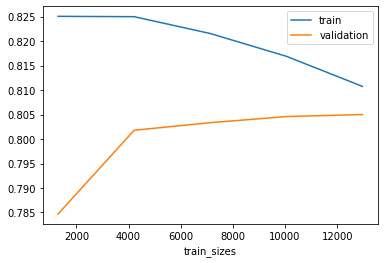

In [13]:
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(my_pipe_lr,X_train,y_train,return_times=True)
                                   
plt.plot(train_sizes, train_scores.mean(axis=1), label='train')
plt.plot(train_sizes, test_scores.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()
plt.show()



## SUPPRIMER LES VALEURS INFLUENTES 

In [14]:
y_pred = my_pipe_lr.predict(X_train)
y_pred.reshape(1,16209)
y_pred

array([[177687.61277818],
       [304991.34499725],
       [ 79101.65779698],
       ...,
       [799453.75319096],
       [545692.74683529],
       [367152.71562071]])

In [15]:
y_train

,price
4549,197500.0
3743,312500.0
11509,156000.0
409,840000.0
5337,474000.0
...,...
18911,920000.0
18108,290000.0
12051,688500.0
12432,485000.0


In [16]:
residual = (y_pred-y_train).abs().sort_values(by='price', axis= 0 , ascending= False)
residual

,price
7252,4.377085e+06
3914,3.394812e+06
9254,3.017216e+06
1448,2.565668e+06
1315,2.334115e+06
...,...
6098,9.181136e+00
17998,7.354427e+00
17736,3.211006e+00
9891,2.005330e+00


In [17]:
to_drop = residual[residual > 500000].index
df_cleaned = df_modelisation.drop(to_drop)   
df_cleaned = df_cleaned.drop('price', axis=1)
df_cleaned

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,year,month
0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,2014,10
10,3,2.50,3560,9796,1.0,0,0,3,8,1860,1700,1965,0,98007,47.6007,-122.145,2015,4
11,2,1.00,1160,6000,1.0,0,0,4,7,860,300,1942,0,98115,47.6900,-122.292,2014,5
14,5,2.00,1810,4850,1.5,0,0,3,7,1810,0,1900,0,98107,47.6700,-122.394,2015,3
15,4,3.00,2950,5000,2.0,0,3,3,9,1980,970,1979,0,98126,47.5714,-122.375,2015,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21595,2,2.25,1530,981,3.0,0,0,3,8,1480,50,2006,0,98103,47.6533,-122.346,2014,10
21599,4,3.00,3990,7838,2.0,0,0,3,9,3990,0,2003,0,98053,47.6857,-122.046,2014,9
21602,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,2014,6
21606,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2015,3


## graphique representant le poids des résidus 

In [18]:
# A TERMINER

In [19]:
sns.scatterplot(residual.index, residual)
plt.title('Poids des résidus')
plt.ylabel('erreur')
plt.show()

/home/kahoul/miniconda3/envs/ykp/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


ValueError: Data must be 1-dimensional

## Entraîner un algorithme de régression linéaire

In [ ]:
X = df_modelisation.drop('price', axis=1)
y = df_modelisation[['price']]
X_train, X_test, y_train, y_test = train_test_split(X,y)
num_col = list(X.select_dtypes(include=[float,int]).columns)
cat_col = list(X.select_dtypes(include=[object]).columns)
my_num_pipe = make_pipeline(StandardScaler(), PolynomialFeatures())
preprocessing = ColumnTransformer([
    ("one_hot", OneHotEncoder(),cat_col),
    ("scaling", my_num_pipe, num_col)
])

In [ ]:
my_pipe_lr = make_pipeline(preprocessing, LinearRegression())

In [ ]:
my_pipe_lr = Pipeline(
    [
        ("preprocessing", preprocessing), 
        ('ridge', LinearRegression())
    ]
)

### Fit - Score - Predict

In [ ]:
my_pipe_lr.fit(X_train, y_train)
print ("my_pipe_lr score : " , my_pipe_lr.score(X_test, y_test))
print ("my_pipe_lr predict : " , my_pipe_lr.predict(X_train))

## NEW Learning curve: courbe d'apprentissage

In [ ]:
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(my_pipe_lr,X_train,y_train,return_times=True)
                                           
                                           
plt.plot(train_sizes, train_scores.mean(axis=1), label='train')
plt.plot(train_sizes, test_scores.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()
plt.show()



## Stocker le modèle de régression choisi à l'aide du module pickle 

In [ ]:
my_pipe_lr
with open("my_pipe_lr.pkl", "wb") as f:
    pickle.dump(my_pipe_lr, f)

def load_from_pickle(name):
    with open(name, "rb") as f:
        return pickle.load(f)


In [ ]:
load_from_pickle("my_pipe_lr.pkl")

# RIDGE

### Pipeline

In [ ]:
my_pipe_ridge = Pipeline(
    [
        ("preprocessing", preprocessing), 
        ('ridge', Ridge())
    ]
)

### Recherche des meilleurs paramètres 

In [ ]:
my_pipe_ridge.get_params()

In [ ]:
hyperparametres = {'ridge__alpha': [0.01,0.1, 0.2,0.5, 1,10]}

In [ ]:
random_search = GridSearchCV(my_pipe_ridge, hyperparametres, cv= 5)
random_search

In [ ]:
random_search.fit(X_train,y_train)

In [ ]:
random_search.best_params_

In [ ]:
my_pipe_ridge.set_params(**random_search.best_params_)

### Fit - Score - Predict

In [ ]:
my_pipe_ridge.fit(X_train, y_train)
print ("my_pipe_ridge score : " , my_pipe_ridge.score(X_test, y_test))
print ("my_pipe_ridge predict : " , my_pipe_ridge.predict(X_train))

# LASSO

### Pipeline

In [ ]:
my_pipe_lasso = make_pipeline(preprocessing, Lasso())

In [ ]:
my_pipe_lasso = Pipeline(
    [
        ("preprocessing", preprocessing), 
        ('lasso', Lasso())
    ]
)

### Fit - Score - Predict

In [ ]:
my_pipe_lasso.fit(X_train, y_train)
print ("my_pipe_lasso score : " , my_pipe_lasso.score(X_test, y_test))
print ("my_pipe_lasso predict : " , my_pipe_lasso.predict(X_train))

# ELASTIC NET 

### Pipeline

In [ ]:
my_pipe_elastic_net = make_pipeline(preprocessing, ElasticNet())

In [ ]:
my_pipe_elastic_net = Pipeline(
    [
        ("preprocessing", preprocessing), 
        ('elastic_net', ElasticNet())
    ]
)

### Fit - Score - Predict

In [ ]:
my_pipe_elastic_net.fit(X_train, y_train)
print ("my_pipe_elastic_net score : " , my_pipe_elastic_net.score(X_test, y_test))
print ("my_pipe_elastic_net predict : " , my_pipe_elastic_net.predict(X_train))

## Comparaison des modèles

In [ ]:
modeles = { 
"my_pipe_lr.score" : my_pipe_lr.score(X_test, y_test), "my_pipe_elastic_net.score ": my_pipe_elastic_net.score(X_test, y_test),
"my_pipe_lasso.score" : my_pipe_lasso.score(X_test, y_test), "my_pipe_ridge.score" : my_pipe_ridge.score(X_test, y_test)
}

modeles = sorted(modeles.items(), key=lambda x: x[1])
modeles

In [ ]:
df_cleaned.to_csv("df_cleaned.csv")  

In [ ]:
df_modelisation_price = df_modelisation["price"]
df_modelisation_price.to_csv("df_modelisation_price.csv")

## Modélisation de la méthode de régression linéaire

In [ ]:
""" plt.scatter(X, y)
plt.plot(X, model.predict(X), c='red') """

In [ ]:
""" plt.plot(df_modelisation2 , df_modelisation_prix,'ro', markersize = 4) #UTILISATION DE LA FONCTION PLOT 
plt.show() """


In [ ]:
""" predictions = model.predict(X_test)
plt.scatter(X_test,y)
plt.plot(X, predictions, c='r') """

## Fonction qui permet de prédire le prix d'une maison

In [ ]:
""" def prediction_maison(model,sqft_living	,grade	,sqft_above	,sqft_living15	,bathrooms,	view	,sqft_basement	,
                bedrooms	,zipcode_98004	,waterfront	,floors	,zipcode_98039,	zipcode_98040	,zipcode_98112,	zipcode_98006,	yr_renovated	,
                zipcode_98033,	zipcode_98105	,sqft_lot,	zipcode_98075,	zipcode_98199	,
                sqft_lot15 ,	zipcode_98001,	zipcode_98042,	zipcode_98023):
    x = np.array([sqft_living	,grade	,sqft_above	,sqft_living15	,bathrooms,	view	,sqft_basement	,
                bedrooms	,zipcode_98004	,waterfront	,floors	,zipcode_98039,	zipcode_98040	,zipcode_98112,	zipcode_98006,	yr_renovated	,
                zipcode_98033,	zipcode_98105	,sqft_lot,	zipcode_98075,	zipcode_98199	,
                sqft_lot15 ,	zipcode_98001,	zipcode_98042,	zipcode_98023]).reshape(1,25)
    print (model.predict(x)) """


In [ ]:
""" #essai de la fonction
prediction_maison(model,50,7,30,48,2,2,0,2,1,0,1,0,0,0,0,1988,0,0,35,0,0,40,0,0,0) """